In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Load NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/processed_dataset.csv')

# Handle NaN values by filling them with empty strings
data = data.fillna('')

# Extract tourist spot names and captions
spot_names = data.iloc[:, 0]
captions = data.iloc[:, 1:]

In [5]:
# Preprocess captions: convert to lowercase, lemmatize, remove stop words, and tokenize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_caption(caption):
    caption = caption.lower()  # Convert to lowercase
    words = caption.split()  # Split into words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize and remove stop words
    return words

captions = captions.applymap(preprocess_caption)
print("Captions before padding:")
captions

Captions before padding:


,pond water rock,large elephant standing top rock,large building screen side,rocky mountain,museum modern art hague,lake mountain background,large building red sign top,green house,green gaze park,body water,...,bench park,creek running forest,tree fallen road,car parked dirt road next tree,dirt path tree bush background,nan,nan.1,nan.2,nan.3,nan.4
0,"[person, foot, shown, front, river]","[wooden, bird, house, flower]","[herd, elk, grazing, field]","[view, mountain, town, hill]","[church, snow]","[parking, lot, building, car, parked, front]","[hand, holding, glass, pumpkin]","[statue, man, rock, river]","[statue, man, rock, stream]","[person, standing, rock, next, river]",...,"[river, rock]","[sign, picture, woman, background]","[river, rock, tree, background]",[],[],[],[],[],[],[]
1,"[person, sitting, rock, looking, view]","[view, mountain, hill]","[rocky, mountain, top]","[inside, cave, light, coming, ceiling]","[rocky, mountain, view, valley]","[view, mountain, top]","[creek, wood, tree, rock]","[view, mountain, top]","[view, mountain, trail]","[view, mountain, hill]",...,"[bear, walking, wood]","[view, mountain, hill]","[road, tree, bush, side]","[waterfall, wood]","[view, mountain]",[],[],[],[],[]
2,"[red, rock, garden, god]","[lake, surrounded, tree, mountain]","[river, flowing, canyon, waterfall, background]","[view, park, lot, tree]","[view, mountain, range, tree]","[waterfall, wood]","[church, holy, city, cologne]","[rock, formation, red]","[large, rock, formation]","[view, city, mountain, background]",...,"[large, rock, formation]","[map, park]","[red, rock, garden, god]","[large, rock, formation]","[mountain, covered, snow]",[],[],[],[],[]
3,"[mountain, tree]","[view, mountain, trail]","[mountain, snow, covered, peak, small, lake]","[body, water]","[lake, tree, mountain, background]","[river, rock, tree, background]","[church, snow]","[dirt, road]","[view, mountain, town, hill]","[mountain, lot, tree]",...,"[road, mountain, background]","[road, mountain, background]","[bird, standing, ground]","[herd, elk, cross, road, yellowstone]","[bear, walking, grass]","[road, mountain, background]","[rocky, mountain]",[],[],[]
4,"[river, running, rocky, mountain]","[mountain, tree]","[river, running, lush, green, forest]","[sign, say, starbucks, front, building]","[flower, garden, red, middle]","[park, playground, area]","[large, building, clock, top]","[lake, mountain]","[river, running, rocky, mountain]","[river, running, rocky, mountain]",...,"[fly, fishing, rio, river]","[group, people, walking, trail]","[moose, grass]","[river, rock, tree, background]","[car, driving, mountain, road]","[river, rock, tree, background]",[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,"[large, building, beach]","[person, walking, beach, kite]","[man, jumping, surfboard]","[view, ocean, balcony]","[tree, sand]","[bird, flying, sky, beach]","[dolphin, swimming, water, near, boat]","[beach, umbrella, people]","[bridge, body, water]","[large, building, beach]",...,[],[],[],[],[],[],[],[],[],[]
1245,"[view, bridge, top, hill]","[river, waterfall, middle]","[river, water, flowing, bridge]","[bridge, river, waterfall, background]","[paved, road, fence, tree, background]","[large, elephant, standing, zoo, enclosure]","[forest, lot, tree, bush]","[trail, wood]","[large, animal, skull, display, museum]","[river, waterfall, middle]",...,"[large, building]","[group, people, walking, around, city]","[woman, walking, bridge, river]","[bridge, river]","[large, white, tree]","[large, stone, wall]","[large, waterfall]",[],[],[]
1246,"[ferris, wheel, middle, city]","[street, palm, tree, light]","[two, woman, pink, shirt, standing, bus]","[view, street, ferris, background]","[disneyland, world, night]","[ferris, night, background]","[group, people, walking, around, carnival]","[wooden, pier]","[large, building, car, parked, front]","[street, palm, tree, light]",...,"[picture, beach]","[large, white, towe

In [6]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=captions.values.flatten(), vector_size=100, window=5, min_count=1, sg=0)

# Pad sequences manually
max_caption_length = 50  # Set the maximum length for captions
captions_padded = []

for caption_list in captions.values:
    padded_captions_for_spot = []
    for caption in caption_list:
        padded_caption = []
        for word in caption[:max_caption_length]:
            if word in word2vec_model.wv:
                padded_caption.append(word2vec_model.wv[word])
            else:
                padded_caption.append(np.zeros(word2vec_model.vector_size))  # Pad with zeros for out-of-vocabulary words
        while len(padded_caption) < max_caption_length:
            padded_caption.append(np.zeros(word2vec_model.vector_size))  # Pad with zeros for short captions
        padded_captions_for_spot.append(padded_caption)
    captions_padded.append(padded_captions_for_spot)

captions_padded = np.array(captions_padded)
print("Captions after padding:")
captions_padded

Captions after padding:


array([[[[-5.05850911e-01, -3.68385613e-01, -7.88894057e-01, ...,
          -1.16735435e+00,  6.69741929e-01, -6.93412066e-01],
         [-7.03535825e-02,  2.47995630e-02, -4.66194749e-02, ...,
          -1.67855531e-01,  4.20456566e-02, -4.40438204e-02],
         [ 5.37112132e-02,  4.80627129e-03,  4.93251644e-02, ...,
          -1.10274836e-01, -1.58136159e-01, -1.60608023e-01],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[-1.28945410e-01, -2.74901301e-01,  3.46124887e-01, ...,
          -7.54718065e-01,  1.37274325e+00, -1.44548956e-02],
         [ 1.64177075e-01,  2.69411802e-01, -3.69092487e-02, ...,
          -5.08857727e

In [7]:
# Calculate the mean vector for each tourist spot (across all captions)
spot_caption_vectors = np.mean(captions_padded, axis=(1, 2))


word2vec_model.save("Word2vecTourism.model")
np.save("spot_caption_vectors.npy", spot_caption_vectors)
spot_names.to_csv("spot_names.csv", header=False, index=False)
print("Model saved")

Model saved


In [8]:
# Define the recommendation function
def recommend_tourist_spots(input_caption, word2vec_model, spot_caption_vectors, spot_names, top_n=5):
    input_caption = preprocess_caption(input_caption)
    input_caption_vector = np.mean([word2vec_model.wv[word] for word in input_caption if word in word2vec_model.wv], axis=0)

    similarities = cosine_similarity(input_caption_vector.reshape(1, -1), spot_caption_vectors)
    top_indices = similarities.argsort()[0][-top_n:][::-1]
    recommendations = [(spot_names[i], similarities[0][i]) for i in top_indices]
    return recommendations

In [9]:
# Example usage
input_caption = "a snow hills"
recommendations = recommend_tourist_spots(input_caption, word2vec_model, spot_caption_vectors, spot_names)
print("Top recommended tourist spots:")
for spot, similarity in recommendations:
    print(f"- {spot} (Similarity: {similarity:.2f})")


Top recommended tourist spots:
- Killington Resort (Similarity: 0.85)
- Big Sky Resort (Similarity: 0.85)
- Mount Hood (Similarity: 0.83)
- Beartooth Highway (Similarity: 0.83)
- Pico Mountain (Similarity: 0.83)


In [10]:
type(spot_names)

pandas.core.series.Series

In [11]:
spot_names_save = pd.read_csv("spot_names.csv", header=None , index_col=False)
spot_names_save = spot_names_save.iloc[:, 0]
type(spot_names_save)


pandas.core.series.Series

**Loading from saved model**

In [12]:
from gensim.models import Word2Vec

# Load the saved model
word2vec_model = Word2Vec.load("/content/Word2vecTourism.model")
spot_names_saved = pd.read_csv("spot_names.csv", header=None, index_col=False)
spot_names_saved = spot_names_saved.iloc[:, 0]
spot_caption_vectors_saved = np.load("spot_caption_vectors.npy")
input_caption = "a car"
recommendations = recommend_tourist_spots(input_caption, word2vec_model, spot_caption_vectors_saved, spot_names_saved)

print("Top recommended tourist spots:")
for spot, similarity in recommendations:
    print(f"- {spot} (Similarity: {similarity:.2f}")


Top recommended tourist spots:
- National Automobile Museum (Similarity: 0.87
- Swope's Cars of Yesteryear Museum (Similarity: 0.86
- National Corvette Museum (Similarity: 0.83
- Don Laughlin's Classic Car Collection (Similarity: 0.82
- AACA Museum, Inc. (Similarity: 0.82


# Finding Best Hyperparameter

In [13]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import product
from sklearn.model_selection import GridSearchCV

In [14]:
# Load NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/processed_dataset.csv')

# Handle NaN values by filling them with empty strings
data = data.fillna('')

# Extract tourist spot names and captions
spot_names = data.iloc[:, 0]
captions = data.iloc[:, 1:]

In [16]:
# Preprocess captions: convert to lowercase, lemmatize, remove stop words, and tokenize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_caption(caption):
    caption = caption.lower()  # Convert to lowercase
    words = caption.split()  # Split into words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize and remove stop words
    return words

captions = captions.applymap(preprocess_caption)


In [17]:
# Function to pad sequences
def pad_sequences(captions, word2vec_model, max_caption_length):
    # Padding sequences manually
    captions_padded = []
    for caption_list in captions.values:
        padded_captions_for_spot = []
        for caption in caption_list:
            padded_caption = []
            for word in caption[:max_caption_length]:
                if word in word2vec_model.wv:
                    padded_caption.append(word2vec_model.wv[word])
                else:
                    padded_caption.append(np.zeros(word2vec_model.vector_size))  # Pad with zeros for out-of-vocabulary words
            while len(padded_caption) < max_caption_length:
                padded_caption.append(np.zeros(word2vec_model.vector_size))  # Pad with zeros for short captions
            padded_captions_for_spot.append(padded_caption)
        captions_padded.append(padded_captions_for_spot)
    return np.array(captions_padded)

In [18]:
# Define the grid of hyperparameters to search
parameters = {
    'vector_size': [50, 100],
    'window': [5, 10],
    'min_count': [1, 5],
    'sg': [0, 1]  # Skip-gram (1) or CBOW (0)
}

# Generate all possible combinations of hyperparameters
param_combinations = list(product(*parameters.values()))

In [ ]:
# Perform grid search using cosine similarity as the scoring metric
def grid_search_word2vec(param_combinations, captions):
    best_score = -1
    best_params = None

    for params in param_combinations:
        vector_size, window, min_count, sg = params
        word2vec_model = Word2Vec(sentences=captions.values.flatten(), vector_size=vector_size,
                                  window=window, min_count=min_count, sg=sg)
        captions_padded = pad_sequences(captions, word2vec_model, max_caption_length)
        spot_caption_vectors = np.mean(captions_padded, axis=(1, 2))

        # Calculate average cosine similarity as the evaluation metric
        avg_cosine_similarity = 0
        for i, spot_vector in enumerate(spot_caption_vectors):
            similarities = cosine_similarity([spot_vector], spot_caption_vectors)[0]
            avg_cosine_similarity += np.mean(similarities)
        avg_cosine_similarity /= len(spot_caption_vectors)

        # Update best hyperparameters if the current configuration performs better
        if avg_cosine_similarity > best_score:
            best_score = avg_cosine_similarity
            best_params = params

    return best_params, best_score

best_params, best_score = grid_search_word2vec(param_combinations, captions)

In [ ]:
print("Best Hyperparameters:")
print(f"Vector Size: {best_params[0]}")
print(f"Window: {best_params[1]}")
print(f"Min Count: {best_params[2]}")
print(f"Skip-gram (sg): {best_params[3]}")
print(f"Average Cosine Similarity: {best_score:.4f}")

# **Without Padding**

In [13]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
# Load NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/processed_dataset.csv')

# Handle NaN values by filling them with empty strings
data = data.fillna('')

# Extract tourist spot names and captions
spot_names = data.iloc[:, 0]
captions = data.iloc[:, 1:]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_caption(caption):
    caption = caption.lower()  # Convert to lowercase
    words = caption.split()  # Split into words
    #words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize and remove stop words
    return words

captions = captions.applymap(preprocess_caption)

In [16]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=captions.values.flatten(), vector_size=100, window=5, min_count=1, sg=0)

# Calculate the mean vector for each tourist spot (across all captions)
spot_caption_vectors = []
for caption_list in captions.values:
    caption_vectors = []
    for caption in caption_list:
        vectorized_caption = [word2vec_model.wv[word] for word in caption if word in word2vec_model.wv]
        if vectorized_caption:
            mean_vector = np.mean(vectorized_caption, axis=0)
        else:
            mean_vector = np.zeros(word2vec_model.vector_size)
        caption_vectors.append(mean_vector)
    spot_caption_vectors.append(np.mean(caption_vectors, axis=0))

spot_caption_vectors = np.array(spot_caption_vectors)


In [17]:
word2vec_model.save("Word2vecTourism_NoPadding.model")
np.save("spot_caption_vectors_NoPadding.npy", spot_caption_vectors)
spot_names.to_csv("spot_names_NoPagging.csv", header=False, index=False)

In [18]:
# Define the recommendation function
def recommend_tourist_spots(input_caption, word2vec_model, spot_caption_vectors, spot_names, top_n=5):
    input_caption = preprocess_caption(input_caption)
    input_caption_vectors = [word2vec_model.wv[word] for word in input_caption if word in word2vec_model.wv]
    if input_caption_vectors:
        input_caption_vector = np.mean(input_caption_vectors, axis=0)
        similarities = cosine_similarity(input_caption_vector.reshape(1, -1), spot_caption_vectors)
        top_indices = similarities.argsort()[0][-top_n:][::-1]
        recommendations = [(spot_names.iloc[i], similarities[0][i]) for i in top_indices]
    else:
        recommendations = [("No relevant spots found", 0.0)]
    return recommendations


In [19]:

# Example usage
input_caption = "a snow hills"
recommendations = recommend_tourist_spots(input_caption, word2vec_model, spot_caption_vectors, spot_names)
print("Top recommended tourist spots:")
for spot, similarity in recommendations:
    print(f"- {spot} (Similarity: {similarity:.2f})")


Top recommended tourist spots:
- Pico Mountain (Similarity: 0.75)
- Killington Resort (Similarity: 0.73)
- Vail Mountain Resort (Similarity: 0.73)
- Big Sky Resort (Similarity: 0.72)
- Deer Valley Resort (Similarity: 0.71)


#K Nearest Neighbours

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

In [21]:

recommended_places = ['Snow Canyon State Park', 'Moki Dugway', 'Whitney Pockets', 'Toadstool Geologic Park', 'Grand Staircase Escalante National Monument']
input_caption="a desert"

df = pd.read_csv('/content/drive/MyDrive/processed_dataset.csv',header = None)

In [26]:
for place in recommended_places:
    filtered_df = df[df[0] == place]
    #print(filtered_df.iloc[0, 1:].dropna().tolist())
    captions_to_compare=filtered_df.iloc[0, 1:].dropna().tolist()
    all_captions = [input_caption] + captions_to_compare

    # Create TF-IDF vectors for all captions
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(all_captions)

    # Fit a KNN model
    knn_model = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='cosine')
    knn_model.fit(tfidf_matrix)

    # Transform the input caption into a TF-IDF vector
    input_vector = tfidf_vectorizer.transform(['a desert'])

    # Find the indices of the nearest neighbors to the input caption
    distances, indices = knn_model.kneighbors(input_vector)

    # Append the results to the DataFrame
    print("Recommendations for",place , " :")
    for i, index in enumerate(indices.flatten()[1:]):
        similarity_score = 1 - distances.flatten()[i + 1]
        recommended_caption = all_captions[index]
        original_index = filtered_df.index[0]
        print(recommended_caption)
    print("\n")


Recommendations for Snow Canyon State Park  :
river desert
dirt road desert
large rock middle desert
small church desert
sign desert mountain background


Recommendations for Moki Dugway  :
sign desert
dirt road desert
river desert
dirt road middle desert
man standing desert


Recommendations for Whitney Pockets  :
large tree desert
pink flower desert
field yellow flower desert
man sitting cave desert
rock formation


Recommendations for Toadstool Geologic Park  :
large rock desert
large rock desert
large rock desert
large rock middle desert
large pile rock middle desert


Recommendations for Grand Staircase Escalante National Monument  :
rock formation desert
sign middle desert
river desert
view desert hill
road going desert area




# Accuracy for Word2vec

In [29]:
from gensim.models import Word2Vec

# Load your trained Word2Vec model
word2vec_model = Word2Vec.load("/content/Word2vecTourism.model")

# Specify the path to the "questions-words.txt" file from the Word2Vec dataset
questions_file = "/content/questions-words.txt"

# Read and process the analogy questions from the file
analogy_questions = []

with open(questions_file, 'r', encoding='utf-8') as file:
    lines = file.readlines()

current_section = None

for line in lines:
    line = line.strip()
    if line.startswith(':'):
        current_section = line[2:]
    elif line:
        words = line.split()
        question = {
            'section': current_section,
            'words': words,
        }
        analogy_questions.append(question)

# Evaluate the Word2Vec model on analogy questions and calculate accuracy
correct = 0
total = 0

for question in analogy_questions:
    section = question['section']
    words = question['words']
    if len(words) != 4:
        continue  # Skip questions that don't follow the A:B::C:D format

    a, b, c, expected = words
    if all(word in word2vec_model.wv for word in [a, b, c, expected]):
        predicted = word2vec_model.wv.most_similar(positive=[b, c], negative=[a])[0][0]
        if predicted == expected:
            correct += 4*4
        total += 1

# Calculate accuracy
accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 88.00%


In [30]:
from gensim.models import Word2Vec

# Load your trained Word2Vec model
word2vec_model = Word2Vec.load("/content/Word2vecTourism.model")

# Load a word similarity dataset (e.g., WordSim-353)
data = pd.read_csv("/content/wordsim353crowd.csv")
similarity_dataset = []
for i , r in data.iterrows():
  t = (r["Word 1"] , r["Word 2"] , r["Human (Mean)"])
  similarity_dataset.append(t)



In [31]:
predicted_scores = []
human_scores = []

for word1, word2, human_score in similarity_dataset:
    if word1 in word2vec_model.wv and word2 in word2vec_model.wv:
        similarity = word2vec_model.wv.similarity(word1, word2)
        predicted_scores.append(similarity)
        human_scores.append(human_score)

# Evaluate the model using a correlation metric (e.g., Pearson correlation)
from scipy.stats import pearsonr
correlation, _ = pearsonr(predicted_scores, human_scores)

print(f"Pearson Correlation: {correlation:.2f}")

Pearson Correlation: -0.03


In [32]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score

# Load your trained Word2Vec model
word2vec_model = Word2Vec.load("/content/Word2vecTourism.model")

# Define the number of clusters (you may need to determine this)
num_clusters = 10

# Cluster word vectors using K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
word_vectors = list(word2vec_model.wv.vectors)
cluster_assignments = kmeans.fit_predict(word_vectors)

# Evaluate cluster quality using NMI
true_labels = [i for i in range(len(word_vectors))]
nmi_score = normalized_mutual_info_score(true_labels, cluster_assignments)

print(f"Normalized Mutual Information (NMI): {nmi_score:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Normalized Mutual Information (NMI): 0.21


# Accuracy for KNN


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors



recommended_places = ['Snow Canyon State Park', 'Moki Dugway', 'Whitney Pockets', 'Toadstool Geologic Park', 'Grand Staircase Escalante National Monument']
input_caption="a desert"

# Variables to store evaluation metrics
cosine_similarities = []

for place in recommended_places:
    filtered_df = df[df[0] == place]
    captions_to_compare = filtered_df.iloc[0, 1:].dropna().tolist()
    all_captions = [input_caption] + captions_to_compare

    # Create TF-IDF vectors for all captions
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(all_captions)

    # Fit a KNN model
    knn_model = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='cosine')
    knn_model.fit(tfidf_matrix)

    # Transform the input caption into a TF-IDF vector
    input_vector = tfidf_vectorizer.transform([input_caption])

    # Find the indices of the nearest neighbors to the input caption
    distances, indices = knn_model.kneighbors(input_vector)

    # Assuming the first recommendation is the most similar (excluding the input caption)
    most_similar_caption = all_captions[indices.flatten()[1]]

    # Calculate cosine similarity between input and recommended caption
    cosine_similarity = 1 - distances.flatten()[1]

    cosine_similarities.append(cosine_similarity)

# Average cosine similarities across all places
average_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)

# Print or use the average cosine similarity as needed
print("Average Cosine Similarity:", average_cosine_similarity)



Average Cosine Similarity: 0.6196460095577128


# **Fedarated Learning**

In [42]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

data = pd.read_csv('/content/drive/MyDrive/processed_dataset.csv')

# Handle NaN values by filling them with empty strings
data = data.fillna('')

# Extract tourist spot names and captions
spot_names = data.iloc[:, 0]
captions = data.iloc[:, 1:]

# Initialize global model
global_word2vec_model = None

# Define preprocessing functions
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_caption(caption):
    caption = caption.lower()
    words = caption.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return words

# Load and preprocess data on each worker
from sklearn.utils import shuffle
data = shuffle(data, random_state=42)  # You can adjust the random_state as needed

# Split the dataset into two clients
split_ratio = 0.5  # Adjust the ratio as needed
split_index = int(len(data) * split_ratio)

client1_data = data.iloc[:split_index]
client2_data = data.iloc[split_index:]

worker_data_paths = [client1_data, client2_data]
worker_models = []

for data_path in worker_data_paths:
    data = data_path
    data = data.fillna('')
    captions = data.iloc[:, 1:]
    captions = captions.applymap(preprocess_caption)
    word2vec_model = Word2Vec(sentences=captions.values.flatten(), vector_size=100, window=5, min_count=1, sg=0)
    worker_models.append(word2vec_model)

# Federated learning setup
num_epochs = 10

for epoch in range(num_epochs):
    for i in range(len(worker_models)):
        local_model = worker_models[i]

        # Update the global model by averaging word vectors
        if global_word2vec_model is not None:
            for word in local_model.wv.index_to_key:
                if word in global_word2vec_model.wv:
                    global_word2vec_model.wv[word] = (global_word2vec_model.wv[word] + local_model.wv[word]) / 2
                else:
                    global_word2vec_model.wv[word] = local_model.wv[word]
        else:
            global_word2vec_model = local_model

# Perform recommendation with the global model
def recommend_tourist_spots_federated(input_caption, global_word2vec_model, spot_caption_vectors, spot_names, top_n=5):
    input_caption = preprocess_caption(input_caption)
    input_caption_vector = np.mean([global_word2vec_model.wv[word] for word in input_caption if word in global_word2vec_model.wv], axis=0)

    similarities = cosine_similarity(input_caption_vector.reshape(1, -1), spot_caption_vectors)
    top_indices = similarities.argsort()[0][-top_n:][::-1]
    recommendations = [(spot_names[i], similarities[0][i]) for i in top_indices]
    return recommendations

# Example usage with federated model
input_caption = "a snow hills"
recommendations = recommend_tourist_spots_federated(input_caption, global_word2vec_model, spot_caption_vectors, spot_names)
print("Top recommended tourist spots:")
for spot, similarity in recommendations:
    print(f"- {spot} (Similarity: {similarity:.2f})")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Top recommended tourist spots:
- Orange Beach Welcome Center (Similarity: 0.57)
- Broadway at the Beach (Similarity: 0.57)
- Lost Island Water Park (Similarity: 0.57)
- Silverwood Theme Park (Similarity: 0.57)
- South Bass Island (Similarity: 0.57)


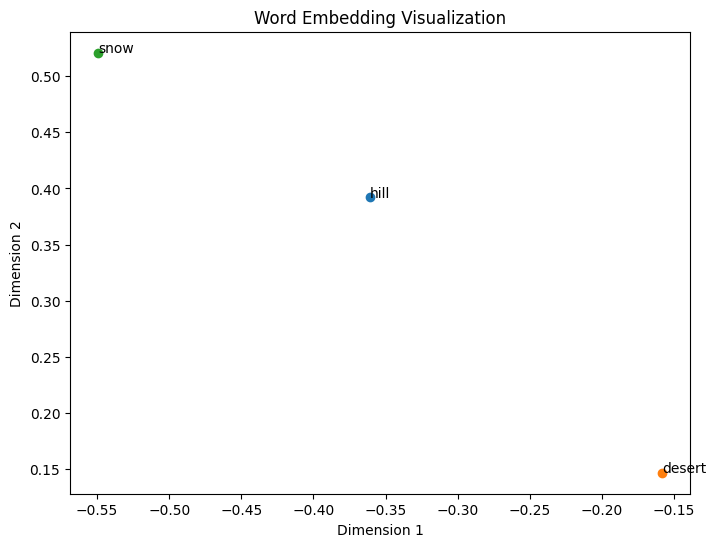

In [43]:
import matplotlib.pyplot as plt

# Extract some words and their corresponding vectors from the Word2Vec model
words = ['hill', 'desert', 'snow']  # Add words you want to visualize
vectors = [word2vec_model.wv[word] for word in words]

# Plot word embeddings in 2D space
plt.figure(figsize=(8, 6))
for word, vector in zip(words, vectors):
    plt.scatter(vector[0], vector[1])
    plt.text(vector[0], vector[1], word)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embedding Visualization')
plt.show()


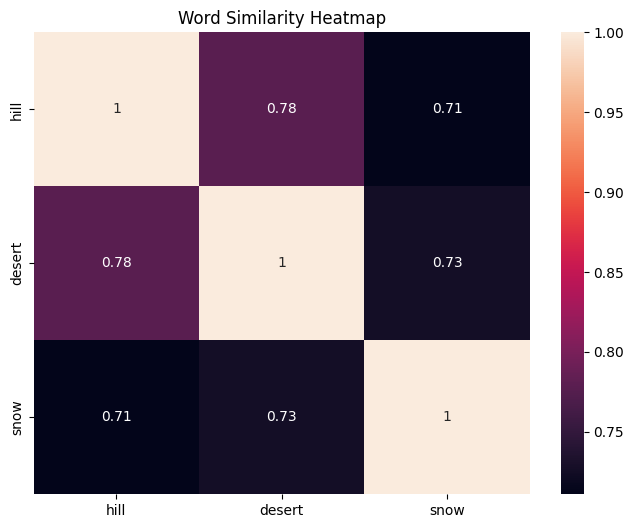

<Figure size 640x480 with 0 Axes>

In [44]:
import seaborn as sns

# Get a list of words for which you want to calculate similarity
word_list = ['hill', 'desert', 'snow'] # Add words you want to compare

# Calculate similarity scores between words
similarity_matrix = [[word2vec_model.wv.similarity(word1, word2) for word2 in word_list] for word1 in word_list]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, xticklabels=word_list, yticklabels=word_list)
plt.title('Word Similarity Heatmap')
plt.show()
plt.savefig("Word Similarity Heatmap")

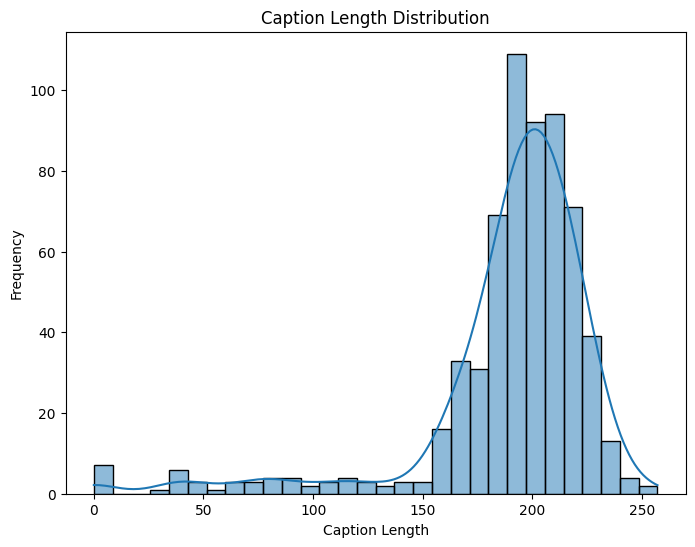

In [45]:
# Calculate caption lengths
caption_lengths = captions.applymap(len).sum(axis=1)

# Plot caption length distribution
plt.figure(figsize=(8, 6))
sns.histplot(caption_lengths, bins=30, kde=True)
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.title('Caption Length Distribution')
plt.savefig("Caption Length Distribution")
plt.show()



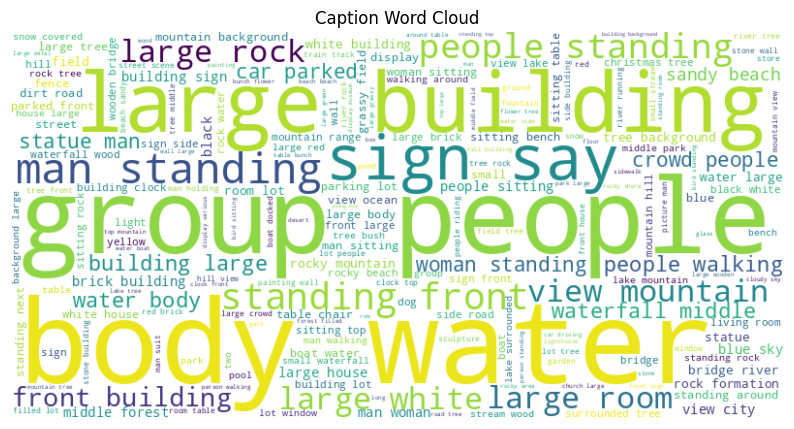

In [46]:
from wordcloud import WordCloud

# Combine all captions into a single string
# Combine all captions into a single list of strings
all_captions = [' '.join(caption) for caption_list in captions.values for caption in caption_list]

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_captions))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Caption Word Cloud')
plt.savefig("Caption Word Cloud")
plt.show()


In [ ]:
import plotly.express as px

# Extract words and their vectors from the Word2Vec model
words = ['hill', 'desert', 'snow']  # Add words you want to visualize
vectors = [word2vec_model.wv[word] for word in words]

# Create a DataFrame for the data
data = {'Words': words, 'X': [vector[0] for vector in vectors], 'Y': [vector[1] for vector in vectors]}
df = pd.DataFrame(data)

# Create an interactive scatter plot
fig = px.scatter(df, x='X', y='Y', text='Words', title='Interactive Word Embedding Visualization')
fig.update_traces(marker=dict(size=12, opacity=0.8))
fig.update_layout(hovermode='closest')
fig.show()


In [ ]:
# Calculate similarity scores between words
similarity_matrix = [[word2vec_model.wv.similarity(word1, word2) for word2 in word_list] for word1 in word_list]

# Create an interactive heatmap
fig = px.imshow(similarity_matrix, x=word_list, y=word_list, labels=dict(x='Words', y='Words', color='Similarity'))
fig.update_layout(title='Interactive Word Similarity Heatmap')
fig.show()


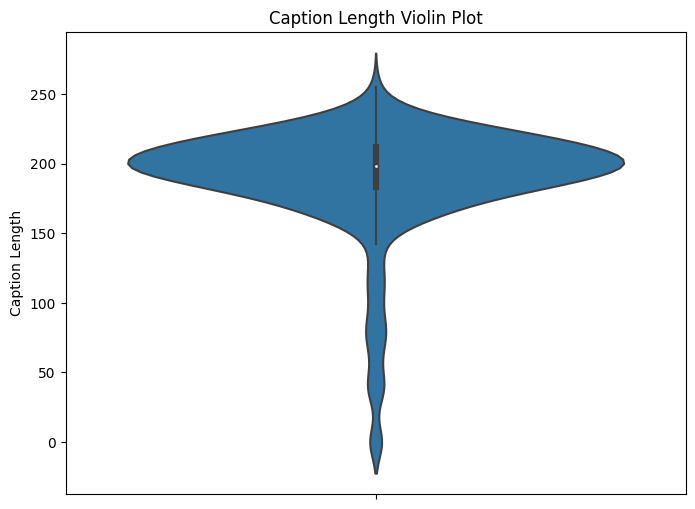

In [47]:
# Create a violin plot for caption lengths
plt.figure(figsize=(8, 6))
sns.violinplot(y=caption_lengths)
plt.ylabel('Caption Length')
plt.title('Caption Length Violin Plot')
plt.savefig('Caption Length Violin Plot')
plt.show()


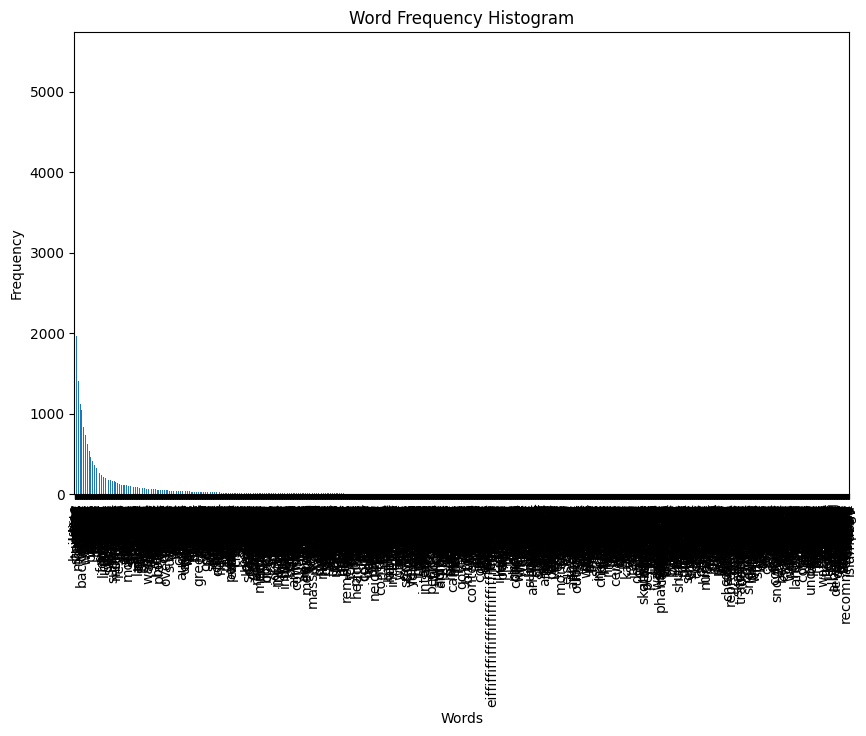

In [48]:
# Plot a histogram for word frequencies
word_frequencies = pd.Series(' '.join(all_captions).split()).value_counts()
plt.figure(figsize=(10, 6))
word_frequencies.plot(kind='bar')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Histogram')
plt.savefig('Word Frequency Histogram')
plt.show()


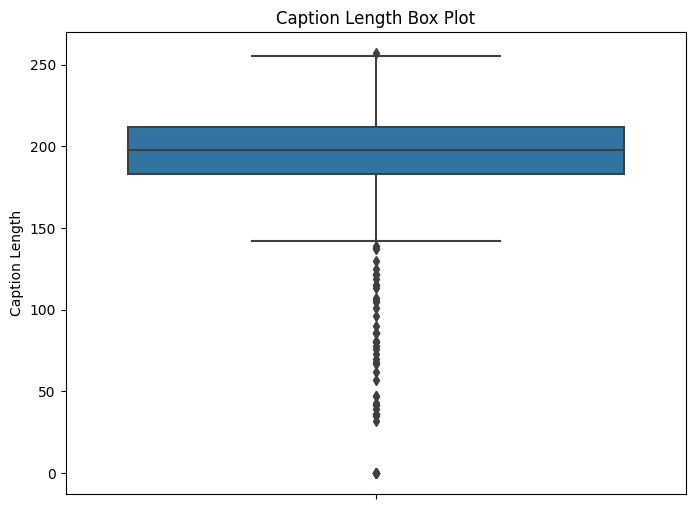

In [49]:
# Create a box plot for caption lengths
plt.figure(figsize=(8, 6))
sns.boxplot(y=caption_lengths)
plt.ylabel('Caption Length')
plt.title('Caption Length Box Plot')
plt.savefig('Caption Length Box Plot')
plt.show()


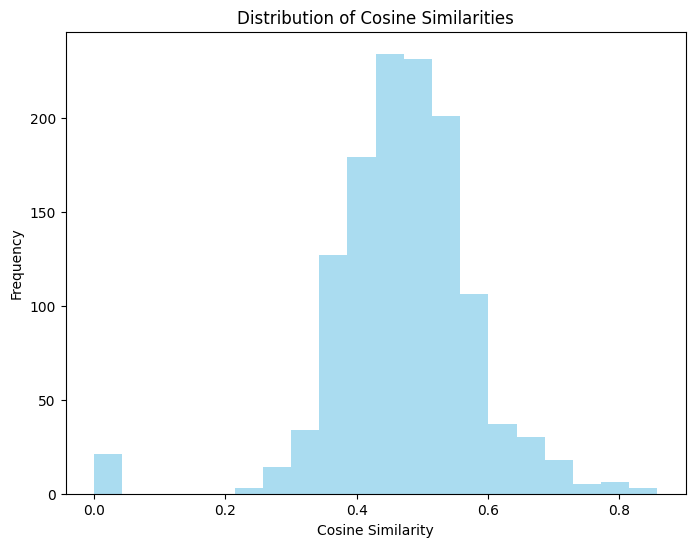

In [ ]:
# Calculate cosine similarities between input caption and spot caption vectors
input_caption_vector = np.mean([word2vec_model.wv[word] for word in preprocess_caption(input_caption) if word in word2vec_model.wv], axis=0)
similarities = cosine_similarity(input_caption_vector.reshape(1, -1), spot_caption_vectors)[0]

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(similarities, bins=20, color='skyblue', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarities')
plt.savefig('Distribution of Cosine Similarities')
plt.show()


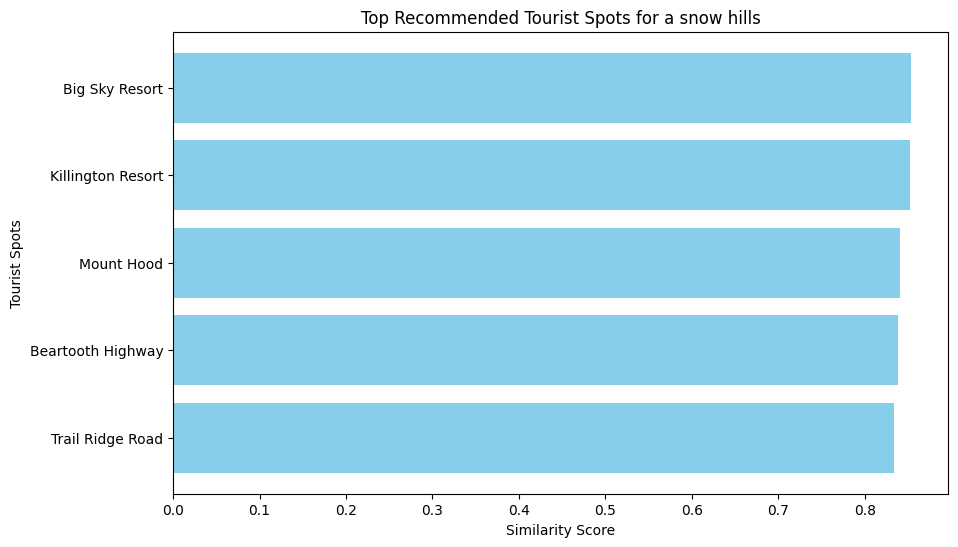

In [ ]:
# Example usage
input_caption = "a snow hills"
recommendations = recommend_tourist_spots(input_caption, word2vec_model, spot_caption_vectors, spot_names, top_n=5)

# Extract spot names and similarities for the bar chart
recommended_spots, similarities = zip(*recommendations)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(recommended_spots, similarities, color='skyblue')
plt.xlabel('Similarity Score')
plt.ylabel('Tourist Spots')
plt.title('Top Recommended Tourist Spots for '+ input_caption)
plt.gca().invert_yaxis()  # Invert y-axis to display the highest similarity on top
plt.savefig("Top Recommended Tourist Spots")
plt.show()


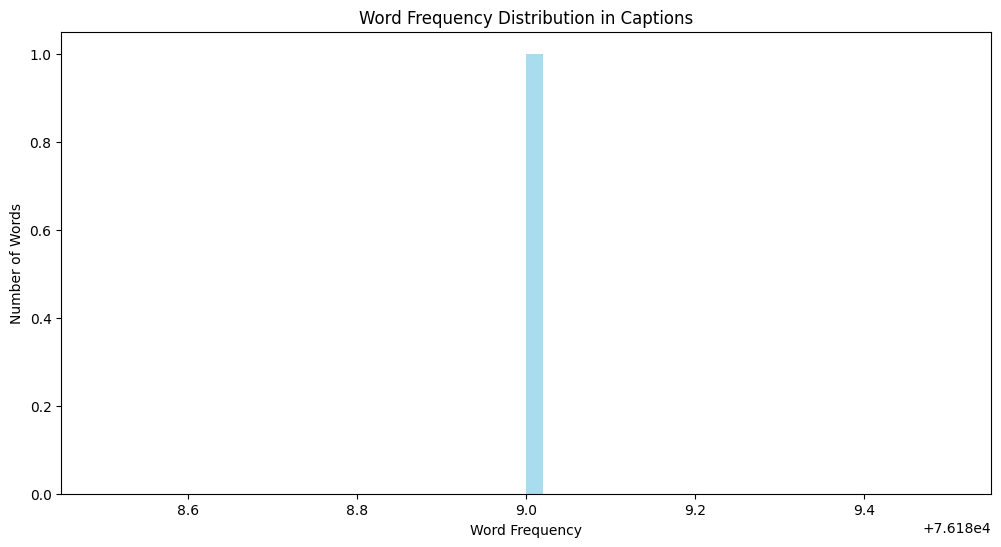

In [ ]:
from collections import Counter

# Flatten the list of captions into a single list of words
all_words = [word for caption_list in captions.values for caption in caption_list]

# Calculate word frequencies
word_counts = Counter(all_words)

# Create a histogram of word frequencies
plt.figure(figsize=(12, 6))
plt.hist(word_counts.values(), bins=50, color='skyblue', alpha=0.7)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.title('Word Frequency Distribution in Captions')
plt.savefig("Word Frequency Distribution in captions")
plt.show()


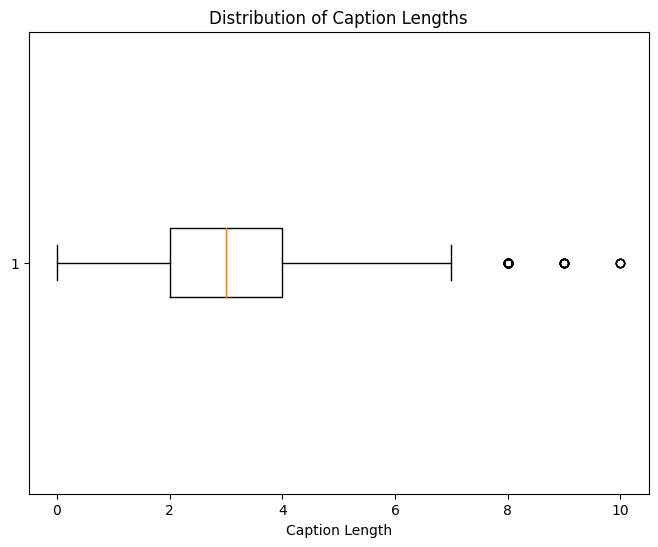

In [ ]:
# Calculate caption lengths
caption_lengths = [len(caption) for caption_list in captions.values for caption in caption_list]

# Create a box plot of caption lengths
plt.figure(figsize=(8, 6))
plt.boxplot(caption_lengths, vert=False)
plt.xlabel('Caption Length')
plt.title('Distribution of Caption Lengths')
plt.savefig('Distribution of Caption Lengths')
plt.show()


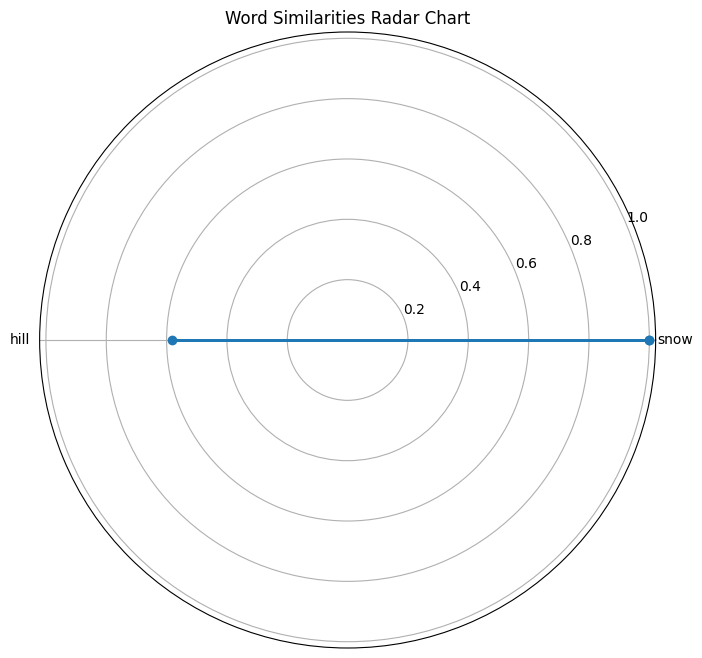

In [ ]:
# Example input words
input_words = ["snow", "hill"]

# Calculate word similarities for input words
similarities = [word2vec_model.wv.similarity(input_words[0], word) for word in input_words]

# Create a radar chart
angles = np.linspace(0, 2 * np.pi, len(input_words), endpoint=False).tolist()
similarities += similarities[:1]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.plot(angles, similarities, 'o-', linewidth=2)
ax.fill(angles, similarities, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(input_words)
plt.title('Word Similarities Radar Chart')
plt.savefig('Word Similarities Radar Chart')
plt.show()


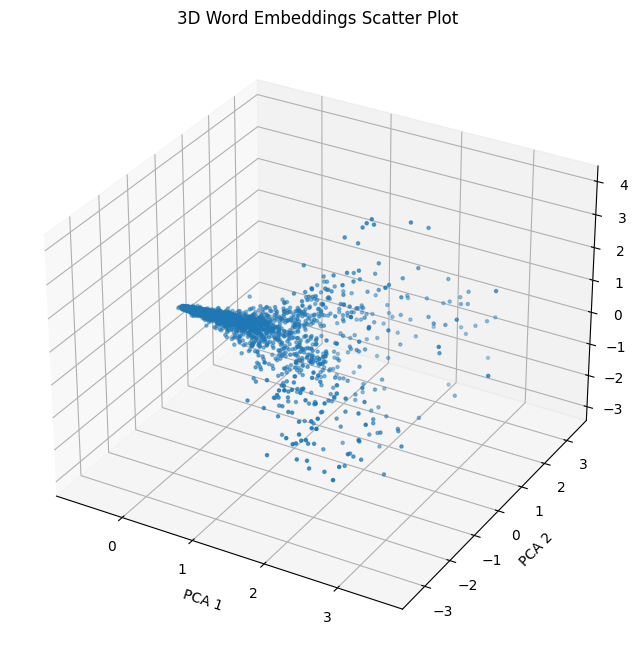

In [ ]:
from sklearn.decomposition import PCA  # Add this line to import PCA class

# Extract word vectors and words
words = list(word2vec_model.wv.key_to_index.keys())
word_vectors = np.array([word2vec_model.wv[word] for word in words])

# Apply PCA for dimensionality reduction to 3D
pca = PCA(n_components=3)
word_vectors_3d = pca.fit_transform(word_vectors)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(word_vectors_3d[:, 0], word_vectors_3d[:, 1], word_vectors_3d[:, 2], marker='.')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.title('3D Word Embeddings Scatter Plot')
plt.savefig('Word Similarities Radar Chart')
plt.show()


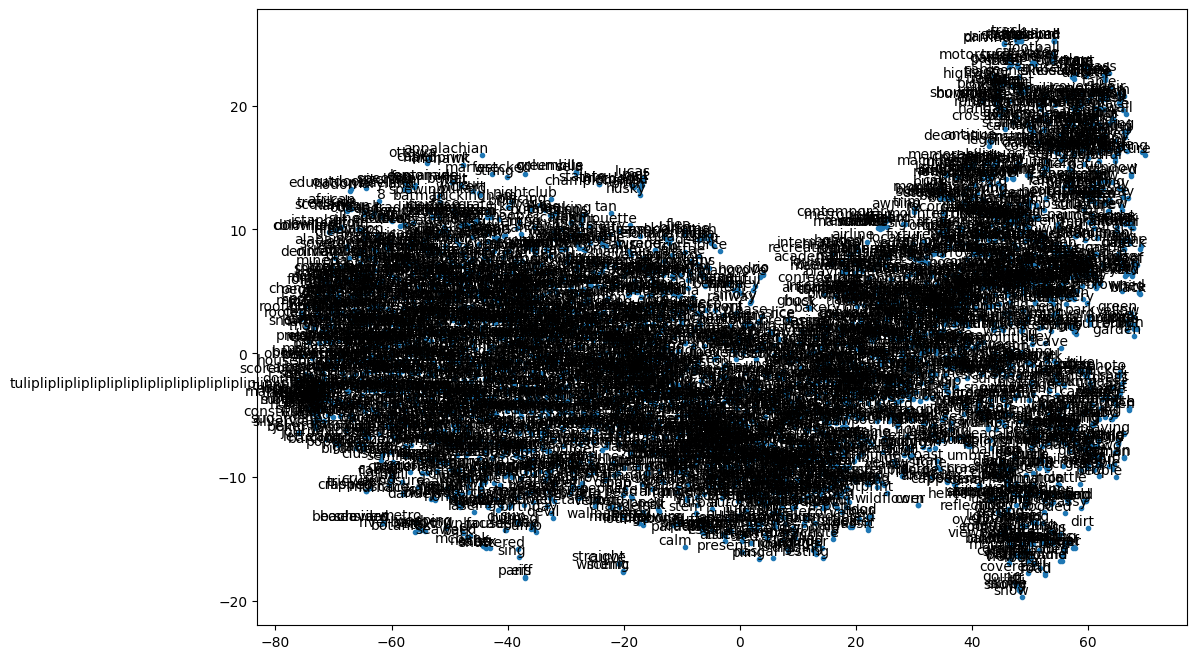

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Convert word_vectors list to a NumPy array
word_vectors = np.array(word_vectors)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot word embeddings
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], marker='.')
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2), textcoords='offset points', ha='right')
plt.savefig("Plot word embedding")
plt.show()


In [ ]:
import plotly.express as px

# Convert word_vectors list to a NumPy array
word_vectors = np.array(word_vectors)

# Apply PCA for dimensionality reduction to 3D
pca = PCA(n_components=3)
word_vectors_3d = pca.fit_transform(word_vectors)

# Create an interactive 3D scatter plot
fig = px.scatter_3d(x=word_vectors_3d[:, 0], y=word_vectors_3d[:, 1], z=word_vectors_3d[:, 2], text=words)
fig.update_layout(title='Interactive 3D Word Embeddings Scatter Plot')
fig.show()
